# Criando um sistema de recomendação básico utilizando Python e Pandas

A proposta desse projeto não é criar um sistema de recomendação real, apenas descrever o mecanismo utilizado para gerar um sistema de recomendação de filmes, fazendo sugestões baseadas em classes de filmes, ratings, número de críticas feitas, dentre outras características. A base de dados é retirada do site https://grouplens.org/. 

O método de recomendação utilizado será o de filtragem colaborativa, que é fundamentada pelo comportamento/ações dos usuários no passado, ou seja, é baseada na similaridade de preferências, gostos, escolhas e atitudes entre usuários, analisando o quão semelhante os usuários são e fazendo recomendações com base nisso.

Ex: Caso usuário A goste dos filmes 1, 2, 3, 4 e o usuário B goste dos filmes 2, 3, 4, 5 então eles aparentam ter gostos semelhantes. A filtragem colaborativa é interessante pois ela é capaz de aprender "sozinha" quais características deve utilizar, sendo assim uma das grandes responsáveis pelos mecanismos de recomendação.


## Importando bibliotecas

In [19]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('white')
%matplotlib inline

##Obtendo dados

In [20]:
column_names = ['user_id', 'item_id', 'rating', 'timestamp']
fonte = "/content/drive/MyDrive/Colab Notebooks/LIT- Machine Learning e Data Science com Phyton/UC4 - Modelos Não Supervisionados/Sistemas de recomendação/u.data"
df = pd.read_csv(fonte, sep='\t', names=column_names)
df

,user_id,item_id,rating,timestamp
0,0,50,5,881250949
1,0,172,5,881250949
2,0,133,1,881250949
3,196,242,3,881250949
4,186,302,3,891717742
...,...,...,...,...
99998,880,476,3,880175444
99999,716,204,5,879795543
100000,276,1090,1,874795795
100001,13,225,2,882399156


In [21]:
# Para trabalhar com o nome dos filmes:
fonte_movie_name = "/content/drive/MyDrive/Colab Notebooks/LIT- Machine Learning e Data Science com Phyton/UC4 - Modelos Não Supervisionados/Sistemas de recomendação/Movie_Id_Titles"
movie_titles = pd.read_csv(fonte_movie_name)

In [22]:
# Concatenando bancos de dados:
df = pd.merge(df,movie_titles,on='item_id')
df.head()

,user_id,item_id,rating,timestamp,title
0,0,50,5,881250949,Star Wars (1977)
1,290,50,5,880473582,Star Wars (1977)
2,79,50,4,891271545,Star Wars (1977)
3,2,50,5,888552084,Star Wars (1977)
4,8,50,5,879362124,Star Wars (1977)


## Análise exploratória dos dados

Dataframes de ratings com classificação média e número de avaliações

In [23]:
df.groupby('title')['rating'].mean().sort_values(ascending=False).head()

title
Marlene Dietrich: Shadow and Light (1996)     5.0
Prefontaine (1997)                            5.0
Santa with Muscles (1996)                     5.0
Star Kid (1997)                               5.0
Someone Else's America (1995)                 5.0
Name: rating, dtype: float64

O agrupamento acima gera um dataframe que organiza os títulos dos filmes por média de "Rating" do menor para o maior, isso demonstra o problema de filmes com poucas críticas, um filme com apenas um/dois rating 5 estaria a frente de outros com várias notas na qual a sua média seria menor que 5. Ou seja, o primeiro caso não descreve bem a realidade. 

In [24]:
# Número de críticas por filme, ordenado de forma descendente.
df.groupby('title')['rating'].count().sort_values(ascending=False).head()

title
Star Wars (1977)             584
Contact (1997)               509
Fargo (1996)                 508
Return of the Jedi (1983)    507
Liar Liar (1997)             485
Name: rating, dtype: int64

In [25]:
# Criando a tabela de média dos ratings, por filme.
ratings = pd.DataFrame(df.groupby('title')['rating'].mean())
ratings.head()

,rating
title,
'Til There Was You (1997),2.333333
1-900 (1994),2.600000
101 Dalmatians (1996),2.908257
12 Angry Men (1957),4.344000
187 (1997),3.024390


In [26]:
# Adicionando a coluna "num of ratings" à tabela feita acima
ratings['num of ratings'] = pd.DataFrame(df.groupby('title')['rating'].count())
ratings.head()

,rating,num of ratings
title,,
'Til There Was You (1997),2.333333,9
1-900 (1994),2.600000,5
101 Dalmatians (1996),2.908257,109
12 Angry Men (1957),4.344000,125
187 (1997),3.024390,41


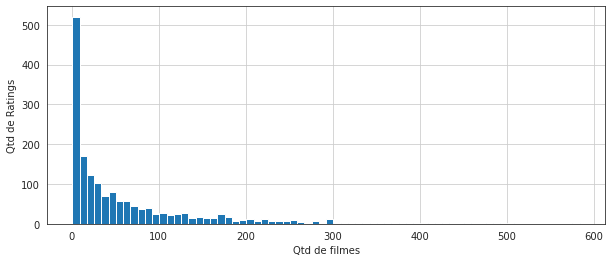

In [30]:
# Plotando histogramas

plt.figure(figsize=(10,4))
plt.xlabel('Qtd de filmes')
plt.ylabel('Qtd de Ratings')
ratings['num of ratings'].hist(bins=70)

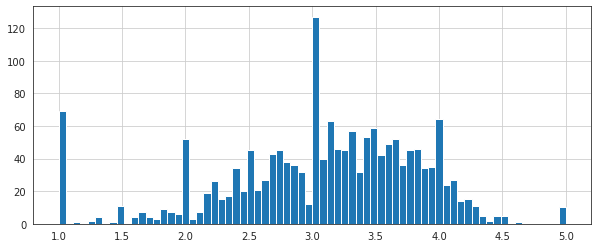

In [35]:
plt.figure(figsize=(10,4))
ratings['rating'].hist(bins=70)

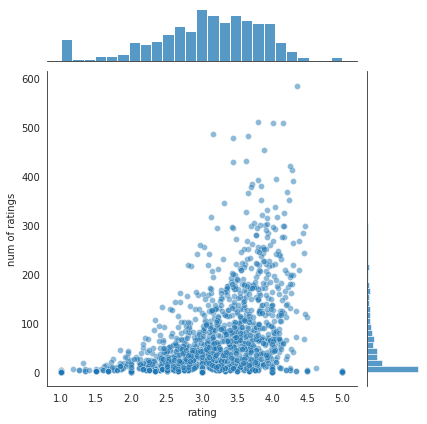

In [34]:
sns.jointplot(x='rating',y='num of ratings',data=ratings,alpha=0.5)

## Criando o sistema de recomendação

Criando uma matriz que possua o user_ID em um eixo e o título do filme em outro, cada célula irá consistir na classificação que o usuário deu para o filme, há diversos valores NaN pois a maioria dos usuários não deu notas para a maioria dos filmes.

In [36]:
moviemat = df.pivot_table(index='user_id',columns='title',values='rating')
moviemat.head()

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",8 1/2 (1963),8 Heads in a Duffel Bag (1997),8 Seconds (1994),A Chef in Love (1996),Above the Rim (1994),Absolute Power (1997),"Abyss, The (1989)",Ace Ventura: Pet Detective (1994),Ace Ventura: When Nature Calls (1995),Across the Sea of Time (1995),Addams Family Values (1993),Addicted to Love (1997),"Addiction, The (1995)","Adventures of Pinocchio, The (1996)","Adventures of Priscilla, Queen of the Desert, The (1994)","Adventures of Robin Hood, The (1938)","Affair to Remember, An (1957)","African Queen, The (1951)",Afterglow (1997),"Age of Innocence, The (1993)",Aiqing wansui (1994),Air Bud (1997),Air Force One (1997),"Air Up There, The (1994)",Airheads (1994),Akira (1988),Aladdin (1992),Aladdin and the King of Thieves (1996),Alaska (1996),Albino Alligator (1996),...,"Whole Wide World, The (1996)",Widows' Peak (1994),"Wife, The (1995)",Wild America (1997),Wild Bill (1995),"Wild Bunch, The (1969)",Wild Reeds (1994),Wild Things (1998),William Shakespeare's Romeo and Juliet (1996),Willy Wonka and the Chocolate Factory (1971),Window to Paris (1994),Wings of Courage (1995),Wings of Desire (1987),"Wings of the Dove, The (1997)",Winnie the Pooh and the Blustery Day (1968),"Winter Guest, The (1997)",Wishmaster (1997),With Honors (1994),Withnail and I (1987),Witness (1985),"Wizard of Oz, The (1939)",Wolf (1994),"Woman in Question, The (1950)","Women, The (1939)","Wonderful, Horrible Life of Leni Riefenstahl, The (1993)",Wonderland (1997),"Wooden Man's Bride, The (Wu Kui) (1994)","World of Apu, The (Apur Sansar) (1959)","Wrong Trousers, The (1993)",Wyatt Earp (1994),Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2.0,5.0,NaN,NaN,3.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,4.0,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
# Filmes mais avaliados
ratings.sort_values('num of ratings',ascending=False).head(10)

,rating,num of ratings
title,,
Star Wars (1977),4.359589,584
Contact (1997),3.803536,509
Fargo (1996),4.155512,508
Return of the Jedi (1983),4.007890,507
Liar Liar (1997),3.156701,485
"English Patient, The (1996)",3.656965,481
Scream (1996),3.441423,478
Toy Story (1995),3.878319,452
Air Force One (1997),3.631090,431


Criando exemplos de recomendação:

O usuário 1 assistiu:
- Liar Liar (1997)

O usuário 2 assistiu:
- Independence Day (ID4) (1996)

Avaliações dos usuários para esses dois filmes:

In [53]:
liarliar_user_ratings = moviemat['Liar Liar (1997)']
independeceday_user_ratings = moviemat['Independence Day (ID4) (1996)']
liarliar_user_ratings.head()

user_id
0    NaN
1    NaN
2    1.0
3    2.0
4    5.0
Name: Liar Liar (1997), dtype: float64

### Obtendo as correlações entre duas séries de pandas usando o método corrwith():


Pandas dataframe.corrwith() is used to compute pairwise correlation between rows or columns of two DataFrame objects. If the shape of two dataframe object is not same then the corresponding correlation value will be a NaN value.


fonte: 

https://www.geeksforgeeks.org/python-pandas-dataframe-corrwith/#:~:text=corrwith()%20is%20used%20to,will%20be%20a%20NaN%20value.

In [51]:
similar_to_liarliar = moviemat.corrwith(liarliar_user_ratings)
similar_to_independeceday = moviemat.corrwith(independeceday_user_ratings)

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


Removendo valores de NaN e usando um DataFrame em vez de uma série:

In [55]:
#Liar Liar
corr_liarliar = pd.DataFrame(similar_to_liarliar,columns=['Correlation'])
corr_liarliar.dropna(inplace=True)
corr_liarliar.head()

,Correlation
title,
'Til There Was You (1997),0.118913
101 Dalmatians (1996),0.469765
12 Angry Men (1957),0.066272
187 (1997),0.175145
2 Days in the Valley (1996),0.040739


In [44]:
#Independece Day
corr_independenceday = pd.DataFrame(similar_to_independeceday,columns=['Correlation'])
corr_independenceday.dropna(inplace=True)
corr_independenceday.head()

,Correlation
title,
'Til There Was You (1997),0.867528
1-900 (1994),-1.000000
101 Dalmatians (1996),0.311182
12 Angry Men (1957),0.134572
187 (1997),0.118750


Se classificarmos o quadro de dados por correlação, devemos obter os filmes mais parecidos, porém obtemos alguns resultados que realmente não fazem sentido. Isso ocorre porque há muitos filmes apenas assistidos uma vez por usuários que também assistiram a Toy Story.

A solução é filtrar filmes com volume de notas maior que 200(primeiro histograma).

In [56]:
corr_liarliar = corr_liarliar.join(ratings['num of ratings'])
corr_liarliar.head()

,Correlation,num of ratings
title,,
'Til There Was You (1997),0.118913,9
101 Dalmatians (1996),0.469765,109
12 Angry Men (1957),0.066272,125
187 (1997),0.175145,41
2 Days in the Valley (1996),0.040739,93


In [47]:
corr_independenceday = corr_independenceday.join(ratings['num of ratings'])
corr_independenceday.head()

,Correlation,num of ratings
title,,
'Til There Was You (1997),0.867528,9
1-900 (1994),-1.000000,5
101 Dalmatians (1996),0.311182,109
12 Angry Men (1957),0.134572,125
187 (1997),0.118750,41


Observe como fica a correlação após a filtragem(abaixo):

Os títulos têm muito mais sentido.

In [58]:
corr_liarliar[corr_liarliar['num of ratings']>200].sort_values('Correlation',ascending=False).head()

,Correlation,num of ratings
title,,
Liar Liar (1997),1.000000,485
Indiana Jones and the Last Crusade (1989),0.414427,331
Top Gun (1986),0.405720,220
Back to the Future (1985),0.378028,350
Jurassic Park (1993),0.370770,261


In [59]:
corr_independenceday[corr_independenceday['num of ratings']>200].sort_values('Correlation',ascending=False).head()

,Correlation,num of ratings
title,,
Independence Day (ID4) (1996),1.000000,429
Twister (1996),0.560029,293
"Hunt for Red October, The (1990)",0.510266,227
Top Gun (1986),0.504166,220
Conspiracy Theory (1997),0.478073,295


Acima temos a relação dos filmes recomendados para os dois casos, ignorando a primeira linha, que é apenas uma repetição do filme pesquisado e por isso a correlação de 1.